In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

Here we will analyse the latent space of the neural networks trained in different ways. To do this easily, we need to look at the TSNE or UMAP of the encoding for each sample and the resulting actual value of the objective (adaptation + sensitivity + precision). First we will create the model according to the settings for each run, load its weights, load the real data, run it through the encoder to get the *z*, and plot that with the actual functionality of the circuit.

In [181]:
from evoscaper.model.vae import sample_z
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from bioreaction.misc.misc import load_json_as_dict
import itertools
import numpy as np
import pandas as pd
import json
import jax
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import os

# Load data

In [182]:
dir_src = os.path.join('data', '01_cvae', '2025_02_25__12_42_34')
fn_saves = os.path.join(dir_src, 'saves_2025_02_25__12_42_34_ds0211_sp_KL2e4')
saves_loaded = load_json_as_dict(fn_saves)

# df_hpos = pd.DataFrame(load_json_as_dict('data/03_cvae_multi/2025_01_15__10_59_22/df_hpos_main.json'))
# hpos = df_hpos.iloc[11]
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))

top_write_dir = os.path.join('data', '04_latent', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
config = {'fn_saves': fn_saves}
with open(os.path.join(top_write_dir, 'config.json'), 'w') as json_file:
    json.dump(config, json_file)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

print(dir_src, top_write_dir)

data/01_cvae/2025_02_25__12_42_34 data/04_latent/2025_03_04__21_32_28


In [183]:
# for hpos in df_hpos.iterrows():

(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    _, 
    encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Load latent variables

In [184]:
h_all = encoder(params, rng, np.concatenate([x, cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=False)


cond_rev_all = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
# cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()


In [185]:
def bin_array(data, num_bins=10):
    original_shape = data.shape
    flattened_data = data.flatten()
    bin_edges = np.linspace(flattened_data.min(), flattened_data.max(), num_bins + 1)
    bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    bin_indices = np.clip(np.digitize(flattened_data, bin_edges) - 1, 0, num_bins - 1)
    binned_data = np.array([bin_means[idx] for idx in bin_indices])
    binned_data = binned_data.reshape(original_shape)
    bin_labels = [f"Bin {i}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}), Mean: {bin_means[i]:.2f}"
                 for i in range(num_bins)]
    return binned_data, bin_edges, bin_labels

x_bin_all, edges, labels = bin_array(x_rev_all, num_bins=10)
x_bin_all = np.round(x_bin_all, 1)


In [186]:
plot_energy_spaces = False

if plot_energy_spaces:
    
    def plot_energy_spaces(x_rev_all, cond_rev_all):
        idxs = np.array([[(i, j) for j in range(x_rev_all.shape[-1])] for i in range(x_rev_all.shape[-1])])

        nrows = x_rev_all.shape[-1]
        ncols = x_rev_all.shape[-1]
        fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20),
                                sharex=True, sharey=True)
        for i in range(nrows):
            for j in range(ncols):
                sns.scatterplot(x=x_rev_all[..., idxs[i, j][0]], y=x_rev_all[..., idxs[i, j][1]], hue=cond_rev_all, palette='viridis', ax=axs[i, j],
                                alpha=0.1,
                                legend=True if (np.sum([i, j] != idxs[-1, -1]) == 0) else False)
                axs[i, j].set_title(f"{idxs[i, j][0]} vs. {idxs[i, j][1]}")
                # axs[i, j].set_xlabel(str(idxs[i, j][0]))
                # axs[i, j].set_ylabel(str(idxs[i, j][1]))
                
    plot_energy_spaces(x_rev_all, cond_rev_all)
    plt.savefig(os.path.join(top_write_dir, f"energy_space.png"), dpi=300)

        
    cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
    for i, c in enumerate(np.unique(cond_rev_all_binned)):
        idxs = np.where(cond_rev_all_binned == c)
        x_rev_all_c = x_rev_all[idxs]
        cond_rev_all_c = cond_rev_all_binned[idxs]
        plot_energy_spaces(x_rev_all_c, cond_rev_all_c)
        plt.savefig(os.path.join(top_write_dir, f"energy_space_{c:.2f}.png"), dpi=300)
        plt.close()

# Latent clusters preview

In [ ]:
cond_binned = cond
if not hpos.loc['prep_y_categorical']:
    cond_binned = bin_array(
        cond_rev_all, num_bins=hpos.loc['prep_y_categorical_n_bins'])[0]

In [189]:
n_show = 1000
random_state = 0
rng_key = jax.random.PRNGKey(0)  # Initialize a PRNG key with a seed
idxs_show = jax.random.choice(rng_key, np.arange(len(z_all)), (n_show,), replace=False)

def plot_tsne(tsne_result, hue, ax, title, palette='viridis', f=sns.scatterplot, method='t-SNE'):
    f(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=hue[:len(tsne_result)], palette=palette, s=50, alpha=0.2, ax=ax)
    ax.set_xlabel(f"{method} Dimension 1")
    ax.set_ylabel(f"{method} Dimension 2")
    ax.set_title(title)


def plot2(tsne_result, hue, ax, i_d1, i_d2, hue_label, n_comps, perplexity, palette='viridis', f=sns.scatterplot):
    d = pd.DataFrame(data=np.array([tsne_result[:, i_d1], tsne_result[:, i_d2], hue[:len(tsne_result)]]).T, columns=[f't-SNE Dimension {i_d1+1}', f't-SNE Dimension {i_d2+1}', hue_label])
    f(d, x=f't-SNE Dimension {i_d1+1}', y=f't-SNE Dimension {i_d2+1}', hue=hue_label, palette=palette, s=50, alpha=0.2, ax=ax)
    plt.suptitle(f"t-SNE of Encoder Output (perplexity={perplexity}, n={n_comps}, rnd={random_state}, dimensions {i_d1, i_d2})", fontsize=14)


def plot_tsne_cond(tsne_result, hues, ax, i_d1, i_d2, hue_labels: list, n_comps, perplexity, palette='viridis', f=sns.scatterplot):
    d = pd.DataFrame(data=np.array([tsne_result[:, i_d1], tsne_result[:, i_d2]] + [hues[:len(tsne_result), i] for i in range(hues.shape[-1])]).T, 
                     columns=[f't-SNE Dimension {i_d1+1}', f't-SNE Dimension {i_d2+1}'] + hue_labels)
    for i, hue_label in enumerate(hue_labels):
        f(d, x=f't-SNE Dimension {i_d1+1}', y=f't-SNE Dimension {i_d2+1}', hue=hue_label, palette=palette, s=50, alpha=0.2, ax=ax)
        ax.set_title(hue_label)
    plt.suptitle(f"t-SNE of Encoder Output (perplexity={perplexity}, n={n_comps}, rnd={random_state}, dimensions {i_d1, i_d2})", fontsize=14)
    

def format_with_subscript(text):
    """Convert text like 'RNA_0' to 'RNA₀' with proper subscript formatting"""
    if '_' in text:
        base, subscript = text.split('_', 1)
        return f"{base}$_{{{subscript}}}$"
    return text


# def reduce(z_samples, method='tsne'):
#     # Reduce dimensionality to 2D
#     if method.lower() == 'tsne':
#         reducer = TSNE(n_components=2, random_state=42)
#     elif method.lower() == 'umap':
#         reducer = umap.UMAP(n_components=2, random_state=42)
#     elif method.lower() == 'pca':
#         reducer = PCA(n_components=2, random_state=42)
#     else:
#         raise ValueError(f'Method {method} not supported')
#     z_2d = reducer.fit_transform(z_samples)
#     return z_2d


x_bin = np.round(x_bin_all, 1)
input_species = [format_with_subscript(i) for i in data['sample_name'].unique()]
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i])) for i in range(len(labels_x))))

## TSNE preview

In [190]:

# def visualize_dimred_2d_custom(tsne_result_2, cond, x_bin, labels_cond, labels_x: list, method='TSNE'):
#     if len(labels_cond) == 1:
#         fig = plt.figure(figsize=(20, 5))
#         nrows = 2
#         ncols = 4
#         gs = fig.add_gridspec(nrows, ncols, width_ratios=[2, 1, 1, 1])
#     else:
#         fig = plt.figure(figsize=(20, 5))
#         nrows = 6
#         ncols = 3
#         gs = fig.add_gridspec(nrows, ncols, width_ratios=[3, 2, 2], height_ratios=[2, 2, 2, 2, 2, 2])

#     # Main plots on the left
#     for i, l in enumerate(labels_cond):
#         row1, row2 = nrows // len(labels_cond) * i, nrows // len(labels_cond) * (i + 1)
#         ax_main = fig.add_subplot(gs[row1:row2, 0])  # Span both rows
#         scatter = ax_main.scatter(
#             tsne_result_2[:, 0], tsne_result_2[:, 1], c=cond[:, i], cmap='viridis', alpha=0.6)
#         ax_main.set_title(
#             f'{method} clusters by condition {labels_cond}', fontsize=16)
#         ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
#         ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
#         plt.colorbar(scatter, ax=ax_main, label=labels_cond)

#     # Smaller plots on the right
#     for i in range(x_bin.shape[-1]):
#         row1, row2 = i // (nrows // ncols) * 2, (i // (nrows // ncols) + 1) * 2
#         col = i % (nrows // ncols) + 1
#         ax = fig.add_subplot(gs[row1:row2, col])
#         scatter = ax.scatter(
#             tsne_result_2[:, 0], tsne_result_2[:, 1], c=x_bin[:, i], cmap='plasma', alpha=0.6)
#         ax.set_title(' + '.join(labels_x[i]), fontsize=12)
#         ax.set_xlabel(f'{method} Dimension 1', fontsize=10)
#         ax.set_ylabel(f'{method} Dimension 2', fontsize=10)
#         plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

#     plt.suptitle(f'{method} visualization of latent space', fontsize=18)
#     plt.tight_layout()
#     plt.show()
    
    
# visualize_dimred_2d_custom(tsne_result_2, cond_rev_all[idxs_show], x_bin[idxs_show],
#                            labels_cond=config_dataset.objective_col, 
#                            labels_x=labels_x, method='TSNE')

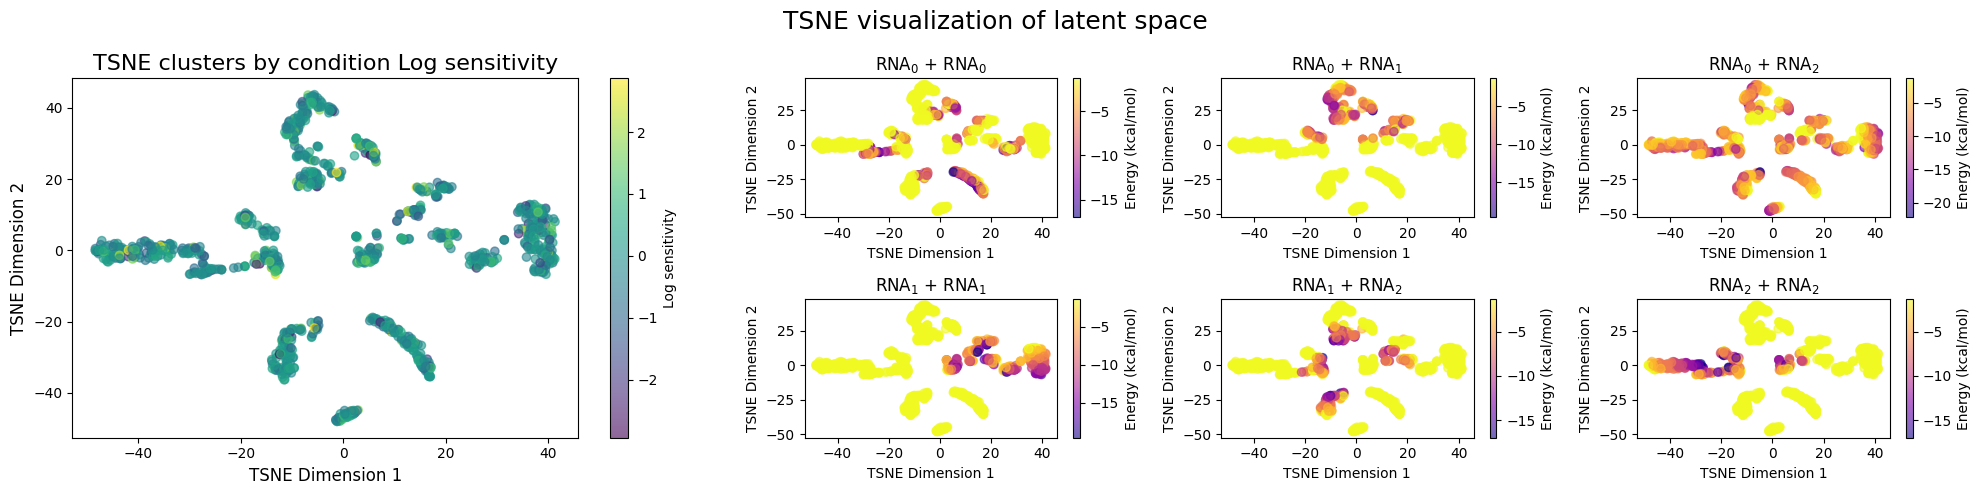

In [191]:
perplexity = 30
tsne = TSNE(n_components=2, random_state=random_state,
            perplexity=perplexity, max_iter=1000)
tsne_result_2 = tsne.fit_transform(h_all[idxs_show])


def visualize_dimred_2d_custom(tsne_result_2, cond, x_bin, label_cond, labels_x: list, method='TSNE'):
    fig = plt.figure(figsize=(20, 5))
    gs = fig.add_gridspec(2, 4, width_ratios=[2, 1, 1, 1])

    # Main plot on the left
    ax_main = fig.add_subplot(gs[:, 0])  # Span both rows
    scatter = ax_main.scatter(
        tsne_result_2[:, 0], tsne_result_2[:, 1], c=cond, cmap='viridis', alpha=0.6)
    ax_main.set_title(
        f'{method} clusters by condition {label_cond}', fontsize=16)
    ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
    ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
    plt.colorbar(scatter, ax=ax_main, label=label_cond)

    # Smaller plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // 3
        col = i % 3 + 1
        ax = fig.add_subplot(gs[row, col])
        scatter = ax.scatter(
            tsne_result_2[:, 0], tsne_result_2[:, 1], c=x_bin[:, i], cmap='plasma', alpha=0.6)
        ax.set_title(' + '.join(labels_x[i]), fontsize=12)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=10)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=10)
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(f'{method} visualization of latent space', fontsize=18)
    plt.tight_layout()
    # plt.savefig(os.path.join(top_write_dir, 'tsne2_custom.png'), dpi=300)
    plt.show()


# Example usage
idx_obj = 0
visualize_dimred_2d_custom(tsne_result_2, cond_rev_all[idxs_show, idx_obj], x_bin[idxs_show],
                           label_cond=config_dataset.objective_col[idx_obj], 
                           labels_x=labels_x, method='TSNE')

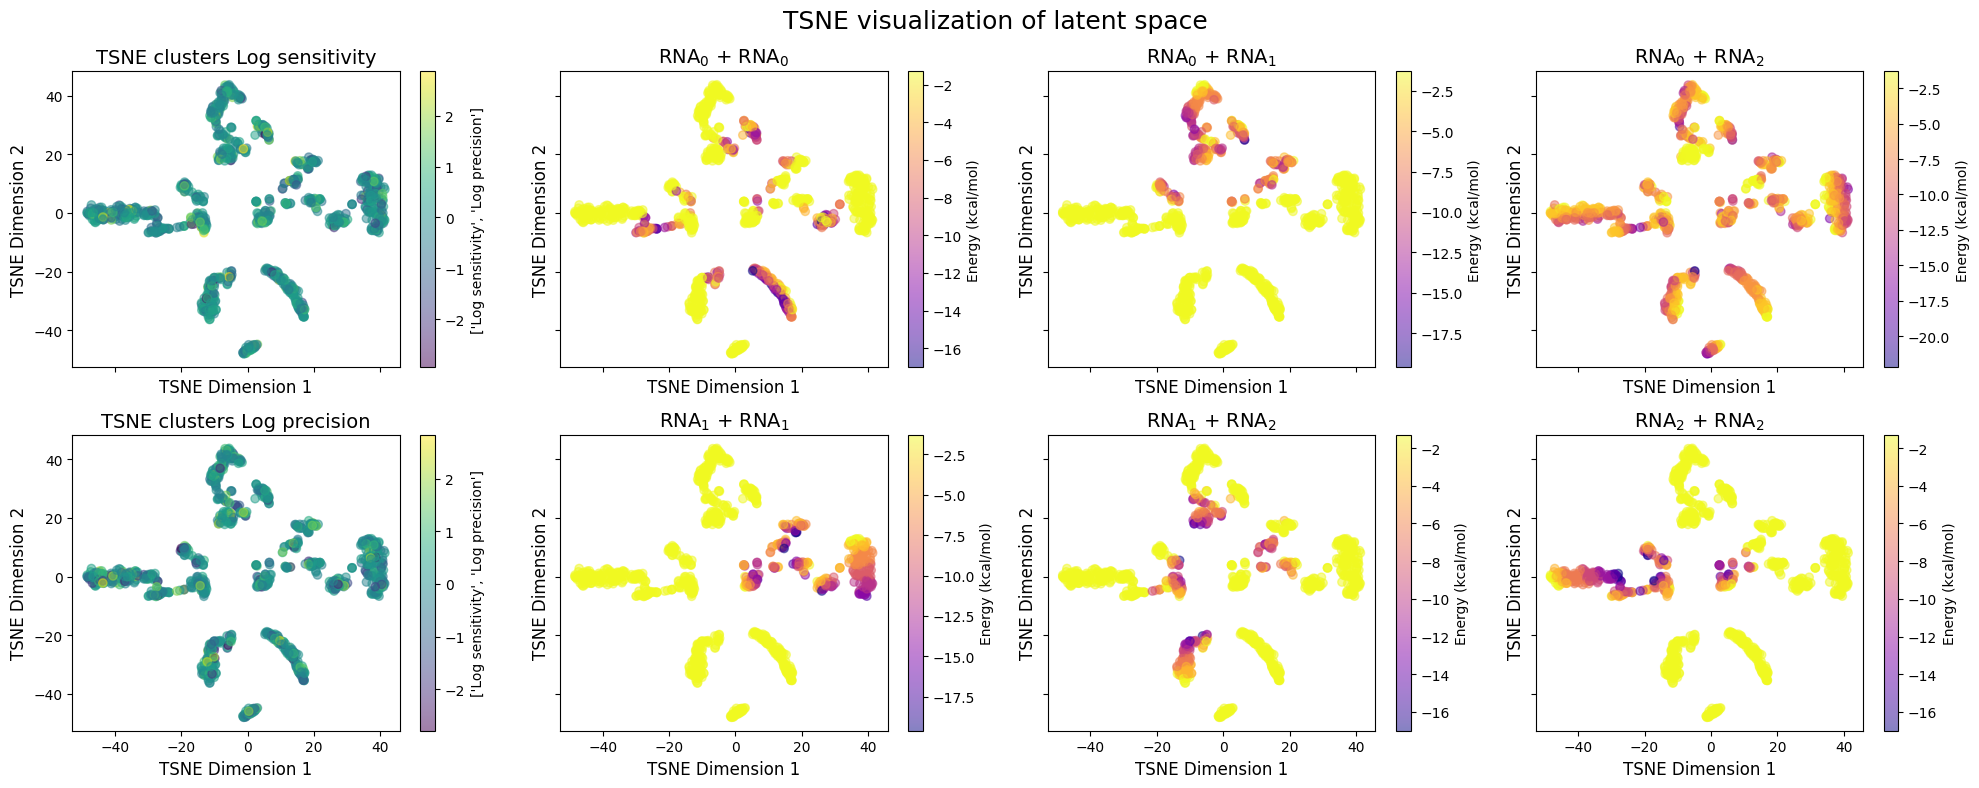

In [192]:
def visualize_dimred_2d_custom_labels(tsne_result_2, cond, x_bin, labels_cond, labels_x: list, method='TSNE'):
    ncols = 4
    fig, axes = plt.subplots(2, ncols, figsize=(
        20, 8), sharex=True, sharey=True)

    # Cond plots on the left
    for i, l in enumerate(labels_cond):
        ax_main = fig.add_subplot(axes[i, 0])  # Span both rows
        scatter = ax_main.scatter(
            tsne_result_2[:, 0], tsne_result_2[:, 1], c=cond[:, i], cmap='viridis', alpha=0.5)
        ax_main.set_title(
            f'{method} clusters {l}', fontsize=14)
        ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
        plt.colorbar(scatter, ax=ax_main, label=labels_cond)

    # Interaction plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // (ncols-1)
        col = i % (ncols-1) + 1
        ax = fig.add_subplot(axes[row, col])
        scatter = ax.scatter(
            tsne_result_2[:, 0], tsne_result_2[:, 1], c=x_bin[:, i], cmap='plasma', alpha=0.5)
        ax.set_title(' + '.join(labels_x[i]), fontsize=14)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=12)
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(f'{method} visualization of latent space', fontsize=18)
    plt.tight_layout()
    # plt.savefig(os.path.join(top_write_dir, 'tsne2_custom.png'), dpi=300)
    plt.show()


# Example usage
visualize_dimred_2d_custom_labels(tsne_result_2, cond_rev_all[idxs_show], x_bin[idxs_show],
                                  labels_cond=config_dataset.objective_col,
                                  labels_x=labels_x, method='TSNE')

## UMAP preview

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


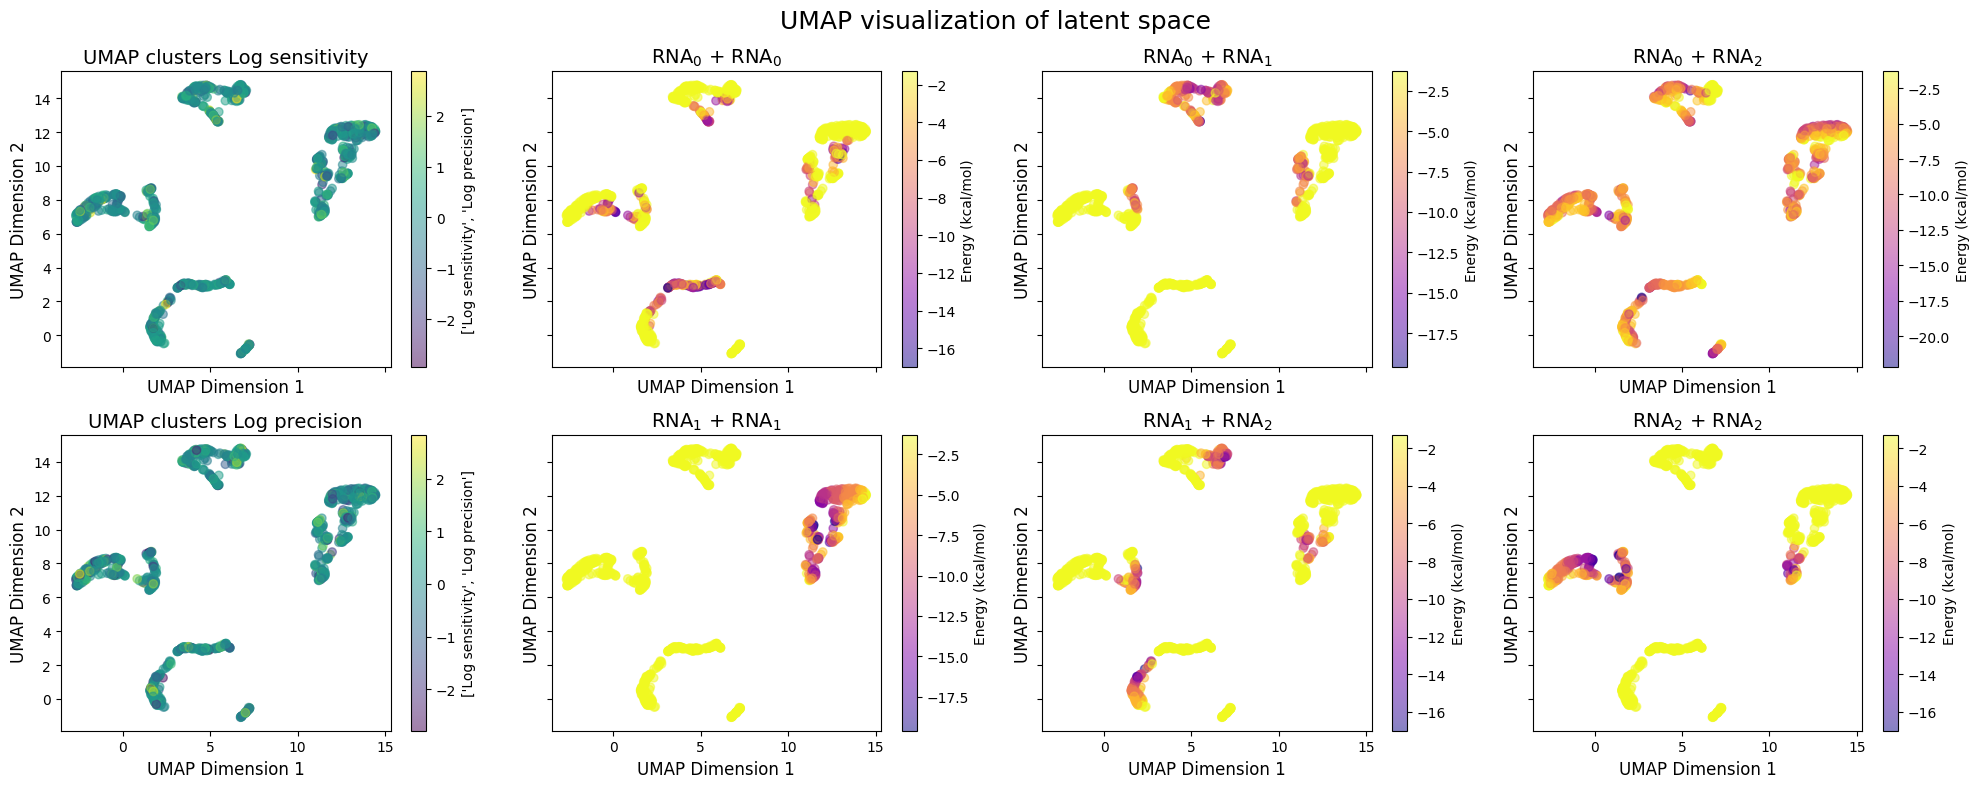

In [193]:
method = 'UMAP'
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         #  metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='pca')
umap_result = reducer_umap.fit_transform(h_all[idxs_show])


visualize_dimred_2d_custom_labels(umap_result, cond_rev_all[idxs_show], x_bin[idxs_show],
                                  labels_cond=config_dataset.objective_col,
                                  labels_x=labels_x, method=method)

## PCA preview

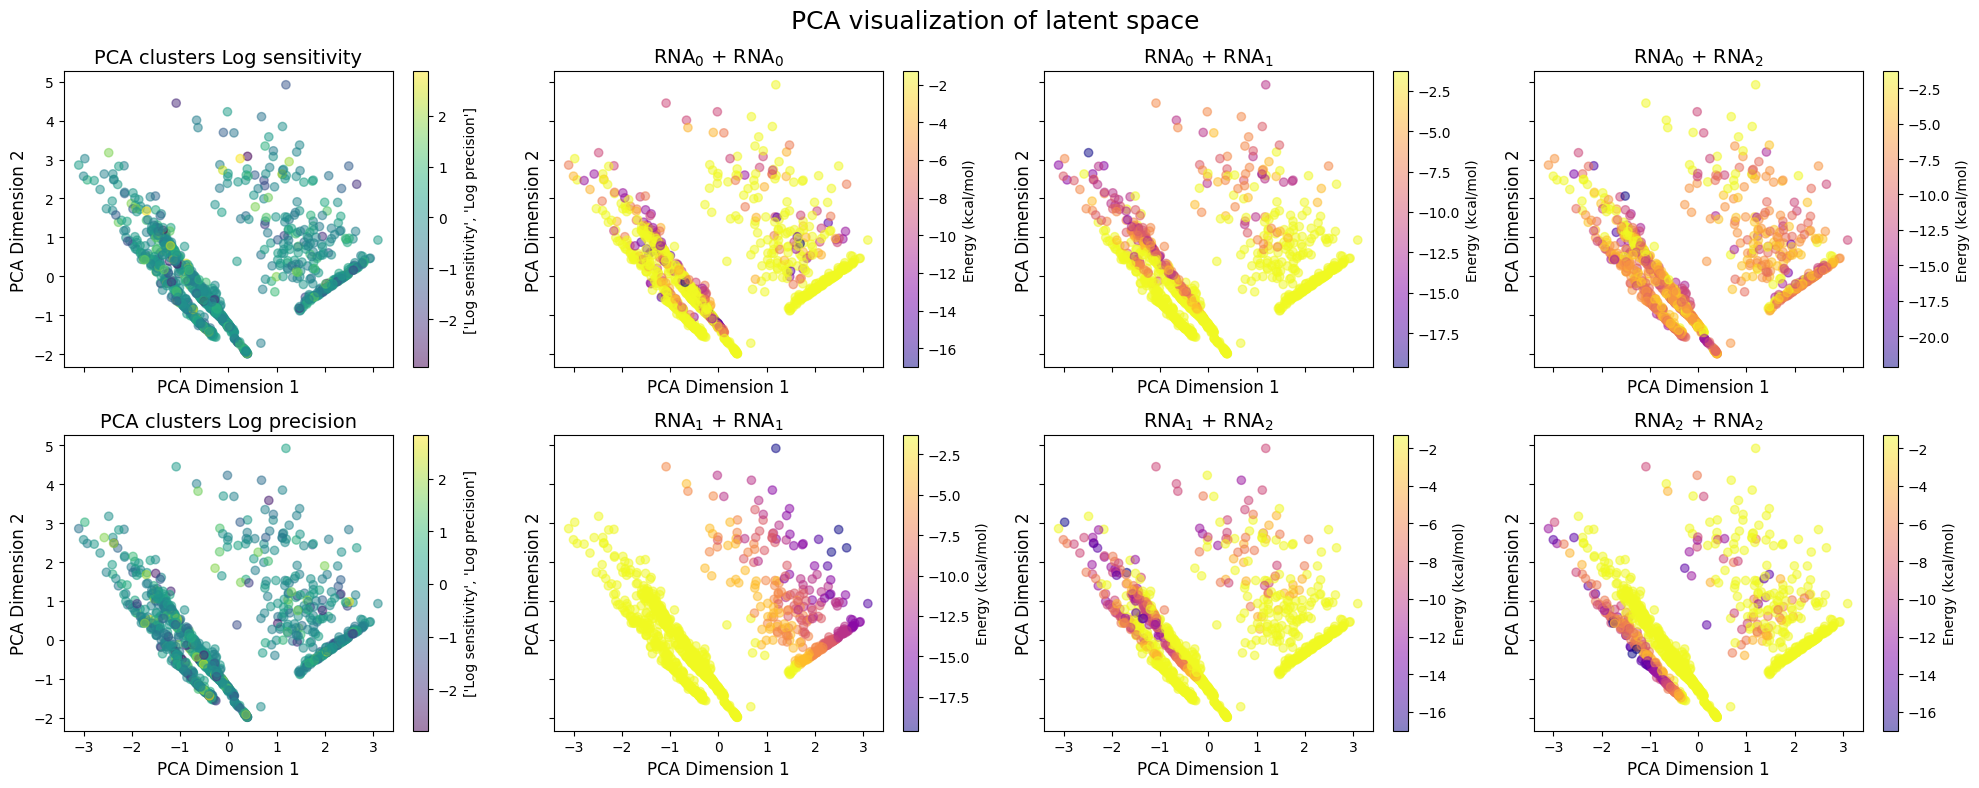

In [194]:
method = 'PCA'
reducer_pca = PCA(n_components=2, random_state=random_state)
pca_result = reducer_pca.fit_transform(h_all[idxs_show])


visualize_dimred_2d_custom_labels(pca_result, cond_rev_all[idxs_show], x_bin[idxs_show],
                                  labels_cond=config_dataset.objective_col,
                                  labels_x=labels_x, method=method)

## MDS preview

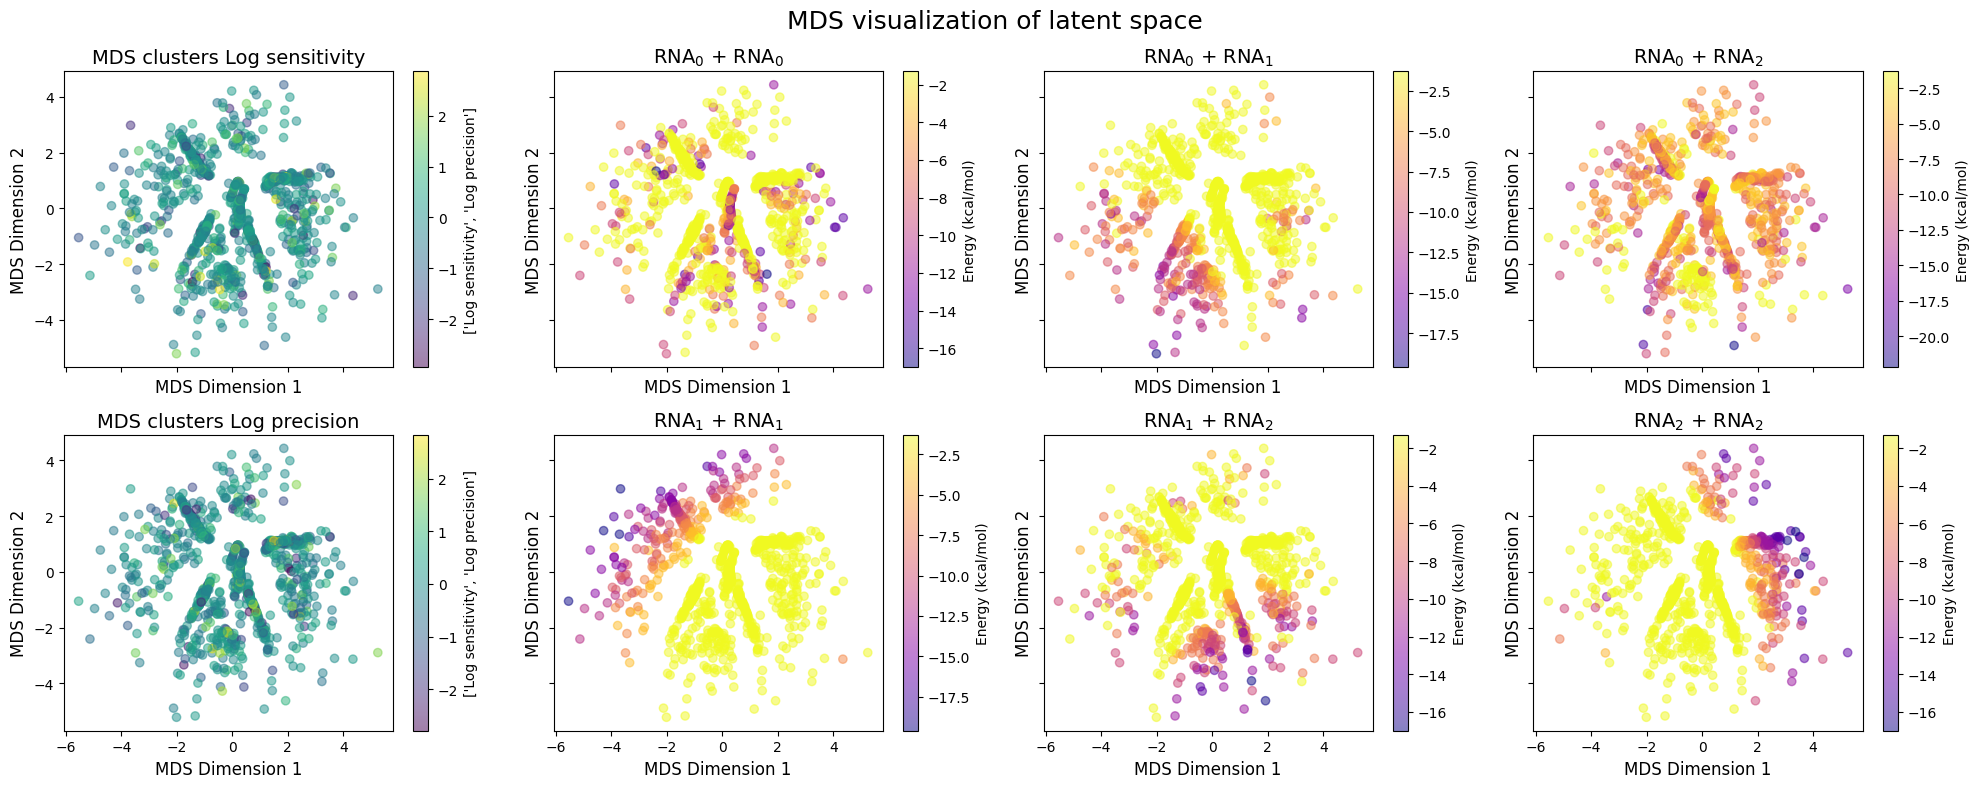

In [195]:
from sklearn.manifold import MDS
method = 'MDS'
mds = MDS(n_components=2, metric=True)
mds_result = mds.fit_transform(h_all[idxs_show])


visualize_dimred_2d_custom_labels(mds_result, cond_rev_all[idxs_show], x_bin[idxs_show],
                                  labels_cond=config_dataset.objective_col,
                                  labels_x=labels_x, method=method)

# TSNE by condition

In [ ]:
perplexity = 30
tsne_results = []
random_state = 0

cond_unique = [np.unique(cond_binned[..., i]) for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))
for i_cond in range(len(cond_unique)):
    if hpos.loc['prep_y_categorical'] and hpos.loc['prep_y_categorical_onehot']:
        idxs_cond = np.where(np.argmax(cond.reshape(
            np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
    else:
        idxs_cond = np.where(np.sum(cond_binned == cond_unique[i_cond], axis=-1))[0]

    h = h_all[idxs_cond]
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity if len(
        h) > perplexity else len(h) - 1, max_iter=1000)
    tsne_result = tsne.fit_transform(h)
    tsne_results.append(tsne_result)

np.save(os.path.join(top_write_dir, 'tsne_results.npy'), np.array(
    [t[:min([len(t) for t in tsne_results])] for t in tsne_results]))

In [ ]:
obj_col = config_dataset.objective_col[0] if len(config_dataset.objective_col) == 1 else config_dataset.objective_col

# for i_cond, tsne_result in enumerate(tsne_results):
#     idxs_cond = np.where(np.argmax(cond.reshape(np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
#     x_bin = np.round(x_bin_all[idxs_cond], 1)
    
#     # plot_tsne(tsne_result, x_bin.sum(axis=-1), perplexity, ax=plt.subplot(111), palette='magma', f=sns.kdeplot)
#     plt.figure(figsize=(8*x.shape[-1] + 1, 6))
#     for i in np.arange(x.shape[-1]):
#         plot_tsne(tsne_result, x_bin[..., i], ax=plt.subplot(1, x.shape[-1] + 1, i+1), title=f"Interaction {i+1}")
#     plot_tsne(tsne_result, cond_rev_all[idxs_cond], ax=plt.subplot(1, x.shape[-1] + 1, i+2), title=obj_col)
#     plt.suptitle(f"t-SNE Visualization of Encoder Output (perplexity={perplexity}, rnd={random_state}): cond = {np.unique(cond_rev_all)[i_cond]:.2f}", fontsize=14)
#     plt.tight_layout()

#     os.makedirs(os.path.join(top_write_dir, 'cond'), exist_ok=True)
#     plt.savefig(os.path.join(top_write_dir, 'cond', f'tsne_cond_{i_cond}.png'), dpi=300)
#     plt.close()

In [ ]:
ncol = x.shape[-1] + 1
fig, axes = plt.subplots(len(tsne_results), ncol, figsize=(6*ncol, 5 * len(tsne_results)), sharex=True, sharey=True)
fig.subplots_adjust(top=0.8)
for i_cond, tsne_result in enumerate(tsne_results):
    if hpos.loc['prep_y_categorical'] and hpos.loc['prep_y_categorical_onehot']:
        # idxs_cond = np.where(np.argmax(cond.reshape(
        #     np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
        # txt_cond = f'cond = {np.unique(cond_rev_all)[i_cond]:.2f}'
        pass
    else:
        idxs_cond = np.where(np.sum(cond_binned == cond_unique[i_cond], axis=-1))[0]
        txt_cond = f'cond = {cond_unique[i_cond].round(2)}'

    x_bin = np.round(x_bin_all[idxs_cond], 1)
    
    p_i = ncol * i_cond
    for i in np.arange(x.shape[-1]):
        plot_tsne(tsne_result, x_bin[..., i], ax=axes[i_cond, i], title=f"Interaction {i+1}, {txt_cond}")
    plot_tsne_cond(tsne_result, cond_rev_all[idxs_cond], ax=axes[i_cond, i + 1], i_d1=0, i_d2=1, hue_labels=obj_col, n_comps=2, perplexity=perplexity)
                #    title=', '.join(obj_col) + f', {txt_cond}')
    # plot_tsne(tsne_result, cond_rev_all[idxs_cond], ax=axes[i_cond, i + 1], title=', '.join(obj_col) + f', {txt_cond}')

plt.suptitle(f"t-SNE Visualization of Encoder Output (perplexity={perplexity}, rnd={random_state}): {txt_cond}", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, f'tsne_cond_all.png'))
plt.close()

/tmp/ipykernel_1356601/1900703774.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(hue_labels), figsize=(5 * len(hue_labels), 5))


Error in callback <function flush_figures at 0x7efee25ea3b0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Text(0.5, 1.0, 'Embedding of model')

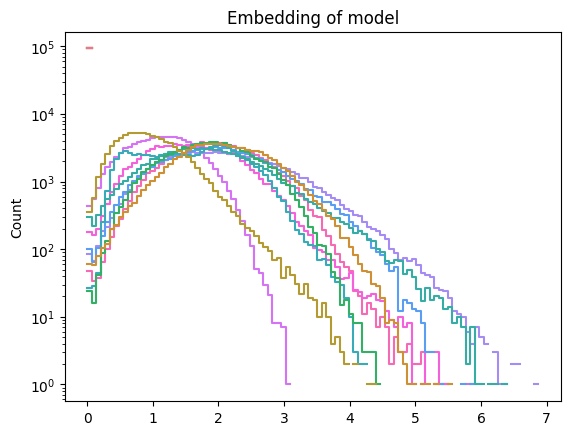

In [ ]:
i_enc = encoder(params, rng, np.concatenate([x, cond], axis=-1))
sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Embedding of model')

# TSNE 2 components

In [ ]:
perplexity = 30
tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, max_iter=1000)
tsne_result_2 = tsne.fit_transform(h_all)

np.save(os.path.join(top_write_dir, 'tsne_result_2.npy'), tsne_result_2)


In [ ]:
x_bin = np.round(x_bin_all, 1)
plt.figure(figsize=(7*x.shape[-1], 6))
for i in np.arange(x.shape[-1]):
    ax=plt.subplot(1, x.shape[-1], i+1)
    plot2(tsne_result_2, x_bin[..., i], ax, 0, 1, f'Energy (kcal)', n_comps=2, perplexity=perplexity)
    plt.title(f"Energy {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'tsne2.png'))
plt.close()

# fig, axes = plt.subplots(1, len(hue_labels), figsize=(5 * len(hue_labels), 5))

cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
plot_tsne_cond(tsne_result_2, cond_rev_all_binned, None, 0, 1, obj_col, n_comps=2, perplexity=perplexity, palette='magma', f=sns.jointplot)
plt.savefig(os.path.join(top_write_dir, f'tsne2_j.png'))
plt.close()

# TSNE 3 components

In [ ]:
perplexity = 30

tsne = TSNE(n_components=3, random_state=random_state, perplexity=perplexity, max_iter=1000)
tsne_result_3 = tsne.fit_transform(h_all)

np.save(os.path.join(top_write_dir, 'tsne_result_3.npy'), tsne_result_3)


In [ ]:
dims = [(0, 1), (0, 2), (1, 2)]
plt.figure(figsize=(8*(x.shape[-1]), 6 * len(dims)))
for ii, (i_d1, i_d2) in enumerate(dims):
    for i in np.arange(x.shape[-1]):
        ax=plt.subplot(len(dims), x.shape[-1], x.shape[-1] * ii + i+1)
        plot2(tsne_result_3, x_bin[..., i], ax, i_d1, i_d2, f'Energy (kcal)', n_comps=3)
        plt.title(f"Energy {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'tsne3.png'), dpi=300)
plt.close()

os.makedirs(os.path.join(top_write_dir, 'tsne3_joint'), exist_ok=True)
for i, (i_d1, i_d2) in enumerate(dims):
    ax=None
    cond_rev_all_binned = bin_array(cond_rev_all, num_bins=10)[0] if not hpos.loc['prep_y_categorical'] else cond_rev_all
    plot_tsne_cond(tsne_result_3, cond_rev_all_binned, ax, i_d1, i_d2, obj_col, n_comps=3, palette='magma', f=sns.jointplot)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'tsne3_joint', f'tsne3_j{i}.png'), dpi=300)
    plt.close()
    


In [ ]:
print(top_write_dir, fn_saves)

data/04_latent/2025_01_26__17_07_59 data/01_cvae/2025_01_26__16_44_57/saves_2025_01_26__16_44_57_sens_kl_5e4_epochs100
